<a href="https://colab.research.google.com/github/cleversonahum/nn_backpropagation/blob/main/nn_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementação de rede neural com back-propagation para problema simples de regressão

Baseado no tutorial ["How to Code a Neural Network with Backpropagation In Python (from scratch)"](https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/).


Em redes neurais com uma única camada uma série de entradas são mapeadas em conexões com os neurônios da camada oculta, que por sua vez levarão todas as entradas em consideração para computar os seus pesos e aplicão funções lineares nas suas saídas para alimentar os neurônios da camada de saída que gerarão a saída da rede neural. Para demonstrar um caso simples de rede neural com backpropagation para problema de regressão utilizaremos a topologia apresentada na figura abaixo. Nessa figura temos uma única entrada na rede neural correspondente a um número que seria a entrada de uma função, temos uma camada oculta com 5 neurônios e uma camada de saída com um único neurônio que terá como saída o valor que aproximaria a função de treinamento. Cada neurônio da camada oculta ou saída possui um peso e um bias associado, por exemplo o neurônio `n1` possui o peso `w1` e o bias `b1` associado.

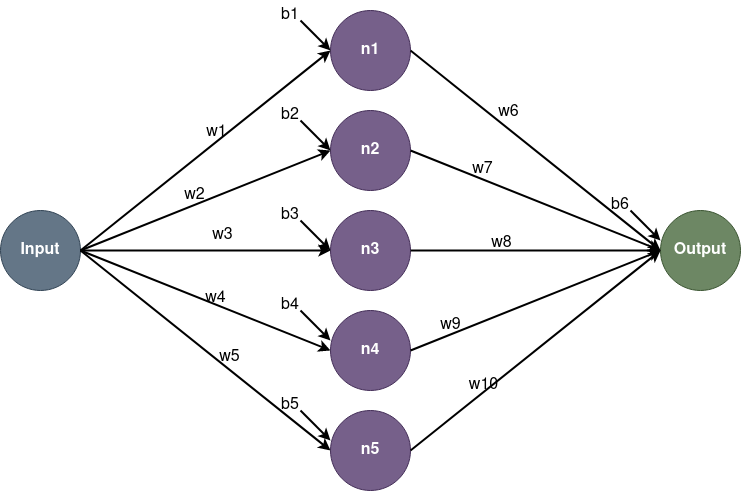

Para criar essa estrutura em código python utilizamos vetores para armazenar os neurônios de cada camada e dicionários para armazenar as informações de cada neurônio. Na saída da célula abaixo é possível notar que os pesos e bias foram inicializados aleatoriamente.

In [1]:
from random import random

def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

def print_net(net):
    for i, layer in enumerate(net):
        print("Camada {}".format(i+1) if i==0 else "Camada de saída")
        for j, neuron in enumerate(layer):
            output = ", Saída: {}".format(neuron["output"]) if "output" in neuron else ""
            delta = ", Delta (erro): {}".format(neuron["delta"]) if "delta" in neuron else ""
            print("Neurônio {}, Pesos + Bias: ".format(j+1), neuron["weights"], output, delta)

net = initialize_network(1, 5, 1)
print_net(net)

Camada 1
Neurônio 1, Pesos + Bias:  [0.5071866350974646, 0.724303359972057]  
Neurônio 2, Pesos + Bias:  [0.6085653218264054, 0.17982148604640658]  
Neurônio 3, Pesos + Bias:  [0.7353218129301433, 0.4249066108395819]  
Neurônio 4, Pesos + Bias:  [0.8188207201710724, 0.9364951562971983]  
Neurônio 5, Pesos + Bias:  [0.36717180511920056, 0.5047877804272431]  
Camada de saída
Neurônio 1, Pesos + Bias:  [0.5943629447954392, 0.6070874085816255, 0.5493918323085369, 0.42242491526677084, 0.5801460713522438, 0.13998734142132496]  


Cada neurônio multiplica cada uma das suas entradas pelos seus respectivos pesos e soma todos os componentes e o bias para gerar a seu valor de ativação. Após isso uma função de ativação é aplicada no valor de ativação gerando por fim a saída do neurônio. A imagem abaixo exemplifica esse processo, que é definido pela fórmula:
\begin{align}
saida=\mathrm{func}(\sum^{N=3}_{i=1}x_i w_i+b)
\end{align}. 
Onde $\mathrm{func}$ representa uma função linear.

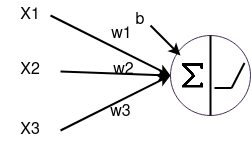

A função `activate()` abaixo é reponsável por gerar o somatório da multiplicação de pesos e entradas do neurônio.

In [2]:
import numpy as np

def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

weights = np.array([2, 4]) # O último é o bias
input = np.array([2])
print("Somatório neurônio: ", activate(weights, input))

Somatório neurônio:  8


Enquanto que a função de ativação é implementada pela função `tranfer()` abaixo. Para implementá-la utilizamos a função de ativação ReLU, que possui a seguinte fórmula:
\begin{align}
\mathit{ReLU}(x) & = max(0,x)
\end{align}

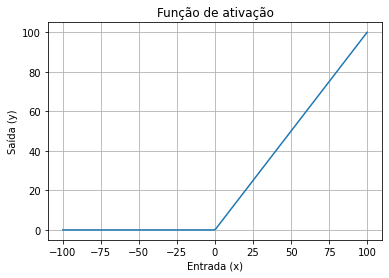

In [3]:
import matplotlib.pyplot as plt

def transfer(activation):
	#return 1.0 / (1.0 + np.exp(-activation)) #tanh
	return np.where(activation<0, 0, activation)

plt.figure()
x_transfer = np.linspace(-100,100,200)
y_transfer = transfer(x_transfer)
plt.title("Função de ativação")
plt.xlabel("Entrada (x)")
plt.ylabel("Saída (y)")
plt.grid()
plt.plot(x_transfer,y_transfer)
plt.show()

A função `forward_propagate()` abaixo é a responsável por utilizar a entrada da rede e alimentar cada um dos neurônios da camada oculta com ela e depois propagar as saídas desses neurônios para a camada de saída gerando por fim a saída da rede. É importante mencionar que apenas os neurônios da camada oculta utilizam a função de ativação linear ReLU, pois como a saída da rede neural pode ter como resposta desejada valores negativos (já que estamos aproximando funções), a função ReLU não seria apropriada. Dessa forma deixamos a camada de saída sem função de ativação.

In [4]:
def forward_propagate(network, row):
	inputs = row
	for i, layer in enumerate(network):
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation) if (i+1) != len(network) else activation
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs
	
output = forward_propagate(net, input)
print ("Saída da rede neural:", output)

Saída da rede neural: [4.8691208113838735]


Para começarmos a falar sobre o algoritmo de atualização de pesos utilizando backpropagation, primeiro é necessário definir a derivada a função de ativação dado que o seu valor será utilizado no cálculo do backpropagation.

\begin{align}
    \mathit{ReLU}\ '(x)= 
\begin{cases}
    1,& \text{if } x\geq 0\\
    0,              & \text{otherwise}
\end{cases}
\end{align}

A derivada da função ReLU é implementada pela função `transfer_derivative()` abaixo.

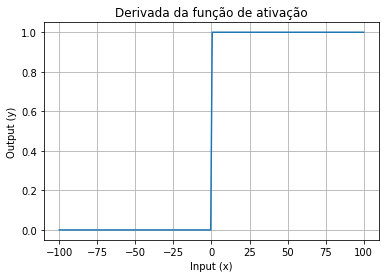

In [5]:
def transfer_derivative(output):
	# return output * (1.0 - output) # Tanh
	return np.where(output<0, 0, 1)

plt.figure()
x_transfer_derivative = np.linspace(-100,100,200)
y_transfer_derivative = transfer_derivative(x_transfer_derivative)
plt.title("Derivada da função de ativação")
plt.xlabel("Input (x)")
plt.ylabel("Output (y)")
plt.grid()
plt.plot(x_transfer_derivative,y_transfer_derivative)
plt.show()

O algoritmo de backpropagation têm o objetivo de calcular o erro no valor dos pesos de acordo com o erro da saída presenciado na rede neural. Então se considerarmos que a saída da rede neural é uma função que têm como parâmetro principal os pesos da rede, podemos então derivar o erro da saída da rede neural em função dos seus pesos, e assim definir de que forma atualizar os seus pesos através da técnica de gradiente descendente para fazer com que a rede neural aprenda o comportamento da função que visa aproximar.

A figura abaixo retirada de \[1\] demonstra de forma geral essa visão. O primeiro passo do algoritmo de backpropagation é fazer a propagação da entrada recebida pela rede e gerar uma saída $O$. Após isso a saída da rede é definida em função dos pesos da rede e funções representando cada uma das atividades dos neurônios (chamada de `ugly composition function`). Uma vez que é a saída é definida em função dos pesos, é calculada a derivada da função de saída de saída em função do peso em análise.

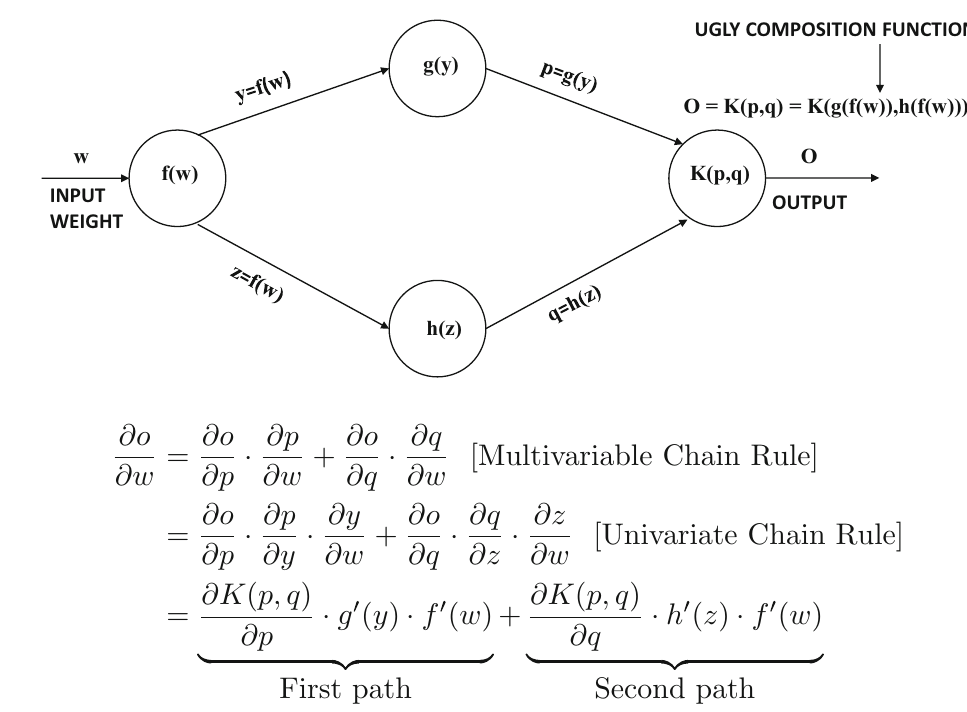

Uma forma simples de definir o erro é $erro = \mathrm{valor\_esperado} - \mathrm{saída\_rede\_neural}$. E podemos então calcular a derivada da função erro em função de um determinado peso da rede. Lembrando que a derivada da $\mathrm{saída\_rede\_neural}$ já foi definida anteriormente e o $\mathrm{valor\_esperado}$ é uma constante. A função `backward_propagate_error` abaixo é responsável por calcular os erros da saída e pra cada neurônio em função de cada um dos pesos criando a variável `delta` dentro do dicionário do neurônio.

In [6]:
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(expected[j] - neuron['output'])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output']) if (i+1) != len(network) else errors[j] * neuron["output"]

print(input)
expected = [5]
backward_propagate_error(net, expected)
print_net(net)

[2]
Camada 1
Neurônio 1, Pesos + Bias:  [0.5071866350974646, 0.724303359972057] , Saída: 1.7386766301669863 , Delta (erro): 0.378767641743189
Neurônio 2, Pesos + Bias:  [0.6085653218264054, 0.17982148604640658] , Saída: 1.3969521296992173 , Delta (erro): 0.3868765172761332
Neurônio 3, Pesos + Bias:  [0.7353218129301433, 0.4249066108395819] , Saída: 1.8955502366998687 , Delta (erro): 0.35010905464184466
Neurônio 4, Pesos + Bias:  [0.8188207201710724, 0.9364951562971983] , Saída: 2.574136596639343 , Delta (erro): 0.26919728150991723
Neurônio 5, Pesos + Bias:  [0.36717180511920056, 0.5047877804272431] , Saída: 1.2391313906656443 , Delta (erro): 0.3697077034105701
Camada de saída
Neurônio 1, Pesos + Bias:  [0.5943629447954392, 0.6070874085816255, 0.5493918323085369, 0.42242491526677084, 0.5801460713522438, 0.13998734142132496] , Saída: 4.8691208113838735 , Delta (erro): 0.6372665810678168


Uma vez que a derivada do erro em relação a cada um dos pesos já foi calculada (com seu valor estando dentro da variável `delta` de cada dicionário do neurônio), finalmente atualizamos os valores dos pesos. A função `update_weight()` abaixo é a responsável por atualizar os pesos da rede neural. Ela utiliza como base o gradiente descendente para realizar essa atualização, gera a seguinte fórmula para atualização do peso:
\begin{align}
\Delta w_i(n) = \mathrm{taxa\_aprendizado}(n)*\mathrm{gradiente\_local(n)}*\mathrm{entrada\_neuronio(n)}
\end{align}

Onde a `taxa_aprendizado` é uma constante que define o tamanho dos passos de correção dos pesos em relação ao gradiente descendente. Logo o novo valor do peso $w_i(n)$ é dado por:
\begin{align}
w_i(n) = w_i(n)+\Delta w_i(n)
\end{align}


In [7]:
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[-1:]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] += l_rate * neuron['delta']

learning_rate = 0.001
update_weights(net, input, learning_rate)
print_net(net)

Camada 1
Neurônio 1, Pesos + Bias:  [0.5079441703809511, 0.7246821276138001] , Saída: 1.7386766301669863 , Delta (erro): 0.378767641743189
Neurônio 2, Pesos + Bias:  [0.6093390748609577, 0.18020836256368272] , Saída: 1.3969521296992173 , Delta (erro): 0.3868765172761332
Neurônio 3, Pesos + Bias:  [0.736022031039427, 0.42525671989422376] , Saída: 1.8955502366998687 , Delta (erro): 0.35010905464184466
Neurônio 4, Pesos + Bias:  [0.8193591147340923, 0.9367643535787081] , Saída: 2.574136596639343 , Delta (erro): 0.26919728150991723
Neurônio 5, Pesos + Bias:  [0.3679112205260217, 0.5051574881306538] , Saída: 1.2391313906656443 , Delta (erro): 0.3697077034105701
Camada de saída
Neurônio 1, Pesos + Bias:  [0.5954709453071282, 0.6079776394892343, 0.550599803127121, 0.42406532649491274, 0.5809357283770671, 0.1406246080023928] , Saída: 4.8691208113838735 , Delta (erro): 0.6372665810678168


In [8]:
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs

print("Entrada: ", input, ", Saída: ",predict(net, input))

Entrada:  [2] , Saída:  [4.885331348382591]


## Preparação da base de dados

A função escolhida para ser aproximada foi a função $y=3x+5$. A base de dados conta com 10000 registros com $x\in[-1, 1]$. O gráfico da função a ser aproximada foi plotado abaixo.

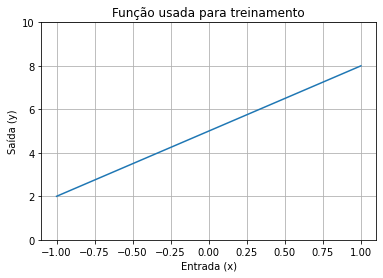

In [9]:
# Função que vamos tentar aproximar
n = 10000 # Número de registros na base de dados
x = np.linspace(-1,1,n)
y = 5+x*3

plt.figure()
plt.title("Função usada para treinamento")
plt.xlabel("Entrada (x)")
plt.ylabel("Saída (y)")
plt.ylim([0,10])
plt.grid()
plt.plot(x,y)
plt.show()

O dataset foi dividido em treino e teste. Sendo que 90% dosregistros são destinados a treinamento e os 10% restantes são destinados para teste.

In [10]:
# Divisão base de dados para treino e teste
from sklearn.model_selection import train_test_split

test_size = 0.1
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y, test_size=test_size)
print("Dimensão entradas para treino = {}\nDimensão saídas para treino = {}\n\nDimensão entradas para teste = {}\nDimensão saídas para teste = {}\n".format(x_train.shape[0], y_train.shape[0], x_test.shape[0], y_test.shape[0]))

Dimensão entradas para treino = 9000
Dimensão saídas para treino = 9000

Dimensão entradas para teste = 1000
Dimensão saídas para teste = 1000



A validação cruzada é implementada considerando K-fold com $K=5$:

In [11]:
# Implementando validação cruzada
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=1)
for train, test in rkf.split(x_train):
	print("Índices treino: %s, Índices validação: %s" % (train, test))

Índices treino: [   0    1    2 ... 8994 8996 8998], Índices validação: [  19   22   23 ... 8995 8997 8999]
Índices treino: [   0    1    3 ... 8996 8997 8999], Índices validação: [   2    8   18 ... 8981 8989 8998]
Índices treino: [   0    2    3 ... 8997 8998 8999], Índices validação: [   1    4    6 ... 8987 8988 8990]
Índices treino: [   0    1    2 ... 8997 8998 8999], Índices validação: [  10   12   15 ... 8986 8994 8996]
Índices treino: [   1    2    4 ... 8997 8998 8999], Índices validação: [   0    3    5 ... 8979 8984 8993]


## Treinamento da rede

Rede neural antes do treinamento:
Camada 1
Neurônio 1, Pesos + Bias:  [0.5504813805859256, 0.8435055290812785]  
Neurônio 2, Pesos + Bias:  [0.5801604207373097, 0.2975067187925686]  
Neurônio 3, Pesos + Bias:  [0.42710625543301883, 0.7480347219595953]  
Neurônio 4, Pesos + Bias:  [0.6497466373032711, 0.7934591436499945]  
Neurônio 5, Pesos + Bias:  [0.5401384300130521, 0.7713975255355199]  
Camada de saída
Neurônio 1, Pesos + Bias:  [0.35529601496106544, 0.24669858493287966, 0.6629676781018681, 0.31252124769186185, 0.41487138497800824, 0.3108487797493774]  


Rede neural depois do treinamento:
Camada 1
Neurônio 1, Pesos + Bias:  [0.7456847175961431, 1.09306231226588] , Saída: 1.641568272653882 , Delta (erro): -5.654178330713501e-09
Neurônio 2, Pesos + Bias:  [0.6867004984831058, 0.4521415991474094] , Saída: 0.9572603276545844 , Delta (erro): -2.4190922240417984e-16
Neurônio 3, Pesos + Bias:  [0.7033399094412021, 1.1165723081790069] , Saída: 1.6339305473969328 , Delta (erro): -7.2855028

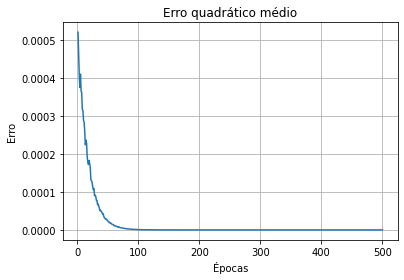

In [12]:
def train_network(network, n_splits, x_train, y_train, l_rate, n_repeats):
	rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
	avg_errors = np.array([])
	for train_idx, valid_idx in rkf.split(x_train):
		for idx in train_idx: # Treino
			outputs = forward_propagate(network, x_train[idx])
			expected = [y_train[idx]]
			backward_propagate_error(network, expected)
			update_weights(network, x_train[idx], l_rate)
		errors = np.array([])
		for idx in valid_idx: #Validação
			outputs = predict(network, x_train[idx])
			expected = y_train[idx]
			errors = np.append(errors, (expected-outputs)**2) # Erro quadrático
		avg_errors = np.append(avg_errors, np.mean(errors))
	
	return avg_errors

net = initialize_network(1, 5, 1)
print("Rede neural antes do treinamento:")
print_net(net)
print("\n")
avg_errors = train_network(net, 5, x_train, y_train, learning_rate, 100)
print("Rede neural depois do treinamento:")
print_net(net)
print("\n")
plt.figure()
plt.title("Erro quadrático médio")
plt.xlabel("Épocas")
plt.ylabel("Erro")
plt.grid()
plt.plot(np.arange(1, len(avg_errors)+1), avg_errors)
plt.show()

In [13]:
def test_network(network, x_test, y_test):
	errors = np.array([])
	for i, x in enumerate(x_test): #Validação
		outputs = predict(network, x)
		expected = y_test[i]
		errors = np.append(errors, (expected-outputs)**2) # Erro quadrático
	print("Erro médio: ", np.mean(errors))

test_network(net, x_test, y_test)

Erro médio:  3.0304787780948603e-18


Abaixo plotamos a saída da função original e a saída da rede neural para percebermos o quão bem a rede neural se saiu para realizar a aproximação da função. Como esperado, já que o erro médio foi extremamente pequeno no teste, a rede neural pôde representar quase que perfeitamente a função original.

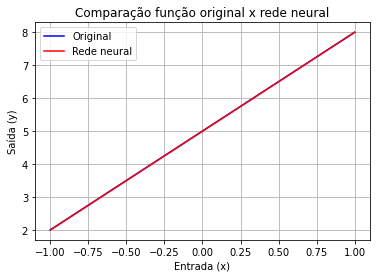

In [14]:
outputs = np.array([])
for value in x:
	outputs = np.append(outputs, predict(net, [value]))

plt.figure()
plt.title("Comparação função original x rede neural")
plt.xlabel("Entrada (x)")
plt.ylabel("Saída (y)")
plt.grid()
plt.plot(x, y, label="Original", color="blue")
plt.plot(x, outputs, label="Rede neural", color="red")
plt.legend()
plt.show()

### Referências

- [1] Aggarwal, C.C., 2018. Neural networks and deep learning. Springer, 10, pp.978-3.